# 1. Thực hiện đọc dữ liệu từ HDFS

In [1]:
import pyspark
print(pyspark.__version__)

3.2.1


In [2]:
import socket

s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
try:
    s.connect(("spark-master", 7077))
    print("Connection successful!")
except Exception as e:
    print("Connection failed:", e)
finally:
    s.close()

Connection successful!


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_extract
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark import SparkContext


spark = (
    SparkSession.builder
    .appName("stock_bigdata")
    .master("spark://spark-master:7077") 
    .getOrCreate()
)

print(spark.version)
print(spark.sparkContext.master)

3.2.1
spark://spark-master:7077


In [4]:
spark

In [5]:
data_path = "hdfs://namenode:9000/data/*.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)

df = df.withColumn("time", F.to_date("time", "yyyy-MM-dd"))
df = df.withColumn("ticker", regexp_extract(input_file_name(), r"([^/]+)\.csv$", 1))
df.printSchema()
df.show()

root
 |-- time: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- ticker: string (nullable = false)

+----------+-----+-----+-----+-----+-------+------+
|      time| open| high|  low|close| volume|ticker|
+----------+-----+-----+-----+-----+-------+------+
|2010-01-04|12.95|12.95|12.95|12.95| 247810|   CII|
|2010-01-05|13.59|13.59|13.59|13.59| 288720|   CII|
|2010-01-06|14.22|14.22| 13.9|14.22|1306580|   CII|
|2010-01-07|14.43|14.85|14.11|14.43|2804340|   CII|
|2010-01-08|14.53|14.64| 13.9| 13.9|1504570|   CII|
|2010-01-11|14.22|14.22|13.59|13.59| 629400|   CII|
|2010-01-12|13.59|13.69|12.95|12.95| 762290|   CII|
|2010-01-13|12.95|13.17|12.43|13.06|1180890|   CII|
|2010-01-14|13.71|13.71|13.71|13.71|  41960|   CII|
|2010-01-15|14.39|14.39|14.29|14.39|2314920|   CII|
|2010-01-18|14.13|14.13|13.68|13.68| 977220|   CII|
|2010-01-1

# 2. Thống kê mô tả chung 

Thực hiện việc khám phá dữ liệu tổng quan ban đầu qua hàm summary() (bao gồm count , mean, stddev,...)

In [6]:
summary_all = df.select("open", "high", "low", "close", "volume").summary()
summary_all.show(truncate=False)

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|open              |high              |low               |close             |volume            |
+-------+------------------+------------------+------------------+------------------+------------------+
|count  |4400101           |4400061           |4400061           |4400060           |4400101           |
|mean   |12.95034035355092 |13.083267059252044|12.79381014945016 |12.949878106207564|328725.8568994212 |
|stddev |18.789752069983088|18.990656300827915|18.590629554462556|18.793004270793418|1964588.9818515815|
|min    |0.0               |0.0               |0.0               |0.0               |0                 |
|25%    |4.4               |4.42              |4.3               |4.39              |0                 |
|50%    |8.2               |8.3               |8.1               |8.2               |1500              |
|75%    |14.86             |15.01             |14.68   

## So sánh các mã theo trung bình giá và khối lượng

So sánh các thống kê cơ bản cho từng mã cổ phiếu, như giá trung bình, độ biến động, giá cao/thấp nhất và khối lượng giao dịch trung bình, sau đó xếp hạng các cổ phiếu theo giá đóng cửa trung bình cao nhất.

In [7]:
stats_by_ticker = df.groupBy("ticker").agg(
    F.count("*").alias("count"),
    F.mean("close").alias("avg_close"),
    F.stddev("close").alias("std_close"),
    F.min("close").alias("min_close"),
    F.max("close").alias("max_close"),
    F.mean("volume").alias("avg_volume")
)

stats_by_ticker.orderBy(F.desc("avg_close")).show(10, truncate=False)

+------+-----+------------------+------------------+---------+---------+------------------+
|ticker|count|avg_close         |std_close         |min_close|max_close|avg_volume        |
+------+-----+------------------+------------------+---------+---------+------------------+
|F88   |51   |1073.6882352941175|44.82081055518216 |888.8    |1180.0   |4317.64705882353  |
|VNZ   |684  |569.5385964912274 |221.59933063923012|240.0    |1358.7   |2038.43567251462  |
|IDP   |1046 |170.75557361376693|65.91339313268556 |42.31    |302.72   |1056.5181644359466|
|XDC   |68   |168.4352941176471 |223.56510939482075|13.5     |999.9    |400.0             |
|GAB   |1254 |162.26692185007704|58.19751617690133 |7.68     |196.9    |42740.47129186603 |
|CMF   |2151 |156.12218503021822|70.86473565009824 |41.35    |390.4    |150.13621571362157|
|HLB   |2125 |146.42398588235326|100.34450618699215|0.0      |430.0    |348.7854117647059 |
|VCF   |3674 |117.52073761567779|57.81979664480004 |18.13    |334.98   |2194.047

## Đo “rủi ro” (độ biến động) của từng mã cổ phiếu.

Tính lợi suất hằng ngày và độ biến động giá (volatility) của từng mã cổ phiếu, qua đó xác định những cổ phiếu có mức biến động mạnh nhất trên thị trường.

In [8]:
from pyspark.sql.window import Window

w = Window.partitionBy("ticker").orderBy("time")
df = df.withColumn("prev_close", F.lag("close").over(w))
df = df.withColumn("daily_return", (F.col("close") - F.col("prev_close")) / F.col("prev_close"))

volatility = df.groupBy("ticker").agg(
    F.mean("daily_return").alias("avg_return"),
    F.stddev("daily_return").alias("volatility")
).orderBy(F.desc("volatility"))

volatility.show(10, truncate=False)

+------+---------------------+-------------------+
|ticker|avg_return           |volatility         |
+------+---------------------+-------------------+
|DNN   |0.10187643867728115  |1.7806845259321122 |
|PTG   |0.022516605067223746 |0.6765261938940811 |
|DKW   |0.3                  |0.4242640687119285 |
|PTX   |0.020913662679470427 |0.33901377412467304|
|XDC   |0.03479982616170331  |0.16189148574393228|
|NS3   |-0.03406195964607938 |0.14718524296935043|
|HHR   |0.0037616430465172443|0.14204573893335298|
|SGS   |0.0030034968148438855|0.1303604999019848 |
|DKG   |0.004405092030349224 |0.12843838980170094|
|NSS   |0.004549897387364335 |0.11585282923734551|
+------+---------------------+-------------------+
only showing top 10 rows



## Phân tích tăng trưởng dài hạn 

In [9]:
growth = df.groupBy("ticker").agg(
    F.first("close").alias("first_close"),
    F.last("close").alias("last_close")
).withColumn("growth_rate", (F.col("last_close") - F.col("first_close")) / F.col("first_close"))

growth.orderBy(F.desc("growth_rate")).show(10, truncate=False)


+------+-----------+----------+------------------+
|ticker|first_close|last_close|growth_rate       |
+------+-----------+----------+------------------+
|CAP   |0.35       |41.4      |117.28571428571429|
|DHT   |1.13       |84.5      |73.77876106194691 |
|TV2   |0.54       |33.7      |61.40740740740741 |
|VE4   |5.06       |259.4     |50.26482213438735 |
|DNC   |1.08       |51.0      |46.22222222222222 |
|PTB   |1.24       |49.65     |39.04032258064516 |
|PDN   |2.4        |93.5      |37.958333333333336|
|THG   |1.43       |51.7      |35.15384615384616 |
|L14   |0.96       |32.1      |32.4375           |
|LHC   |3.07       |99.9      |31.540716612377857|
+------+-----------+----------+------------------+
only showing top 10 rows



## phân tích thanh khoản

Xác định các cổ phiếu có thanh khoản cao nhất (tức được giao dịch nhiều và thường xuyên nhất).

In [10]:
liquidity = df.withColumn("traded_value", F.col("close") * F.col("volume")) \
              .groupBy("ticker") \
              .agg(
                  F.mean("volume").alias("avg_volume"),
                  F.mean("traded_value").alias("avg_traded_value")
              ) \
              .orderBy(F.desc("avg_traded_value"))

liquidity.show(10, truncate=False)


+------+--------------------+--------------------+
|ticker|avg_volume          |avg_traded_value    |
+------+--------------------+--------------------+
|TCX   |1.4668E7            |7.179986E8          |
|VPB   |1.2148206955479452E7|2.2870221234667817E8|
|HPG   |1.0398341804160325E7|2.0345462962350082E8|
|STB   |7991610.270167428   |1.9179722911278564E8|
|TCB   |8567674.38332431    |1.886050708479156E8 |
|ROS   |1.0106185350404313E7|1.7983698735936654E8|
|NVL   |8444376.389368469   |1.762772615475012E8 |
|SSI   |7810239.729325215   |1.5987470988124543E8|
|GEX   |6777247.702204409   |1.534137762184927E8 |
|VHM   |2408054.075512076   |1.4059804584106717E8|
+------+--------------------+--------------------+
only showing top 10 rows



## phân tích biến động theo tháng 

In [11]:
df_month = df.withColumn("month", F.month("time"))
monthly_stats = df_month.groupBy("ticker", "month").agg(
    F.mean("daily_return").alias("avg_month_return"),
    F.stddev("daily_return").alias("month_volatility")
).orderBy("ticker", "month")

monthly_stats.show(20, truncate=False)


+------+-----+----------------------+--------------------+
|ticker|month|avg_month_return      |month_volatility    |
+------+-----+----------------------+--------------------+
|A32   |1    |0.005225978127063213  |0.046559763135155204|
|A32   |2    |1.4260255430765634E-4 |0.06329855163773913 |
|A32   |3    |-0.001903069602235603 |0.041724967354696794|
|A32   |4    |0.0015482929124923446 |0.04702956155542099 |
|A32   |5    |0.0012763706628027812 |0.03689349113546448 |
|A32   |6    |3.775462781556017E-4  |0.03768769416938311 |
|A32   |7    |0.002459934163447651  |0.04696042422424292 |
|A32   |8    |0.002148001776672375  |0.03946234486016893 |
|A32   |9    |0.00399768155289915   |0.040616274005141666|
|A32   |10   |-0.0028582102800716195|0.04363906019026453 |
|A32   |11   |0.002981947147462188  |0.04221551139035171 |
|A32   |12   |0.0035379274108610684 |0.03973713650203381 |
|AAA   |1    |0.0010904287479937202 |0.02653227652018985 |
|AAA   |2    |0.0030968544760234832 |0.02803021002304573

# 3. Phân tích 5 mã ticker tiêu biểu 

Thực hiện việc lựa chọn và kiểm tra dữ liệu của một số nhóm cổ phiếu cụ thể bao gồm FPT, VNM, HPG, SSI và VIC

In [12]:
from pyspark.sql import functions as F

tickers = ['FPT', 'VNM', 'HPG', 'SSI', 'VIC']
df_5 = df.filter(F.col("ticker").isin(tickers))

df_5.select("ticker").distinct().show()


+------+
|ticker|
+------+
|   FPT|
|   HPG|
|   VNM|
|   SSI|
|   VIC|
+------+



Thống kê các mô tả cơ bản của các mã cổ phiếu đã chọn FPT, VNM, HPG, SSI và VIC ( bao gồm giá đóng cửa trung bình(avg_close), độ lệch chuẩn của giá đóng cửa (std_close), giá đóng cửa cao nhất và thấp nhất(min_close và max_close), cuối cùng là khối lượng giao dịch trung bình )

In [13]:
summary_stats = df_5.groupBy("ticker").agg(
    F.mean("close").alias("avg_close"),
    F.stddev("close").alias("std_close"),
    F.min("close").alias("min_close"),
    F.max("close").alias("max_close"),
    F.mean("volume").alias("avg_volume")
)

summary_stats.show(truncate=False)

+------+------------------+------------------+---------+---------+--------------------+
|ticker|avg_close         |std_close         |min_close|max_close|avg_volume          |
+------+------------------+------------------+---------+---------+--------------------+
|FPT   |28.369926433282615|32.483601491617165|3.57     |133.04   |1564311.0568239472  |
|HPG   |9.851626078132933 |8.89236130282186  |0.6      |33.25    |1.0398341804160325E7|
|VNM   |50.122851344495274|24.648344853601166|6.44     |102.22   |1361810.977422628   |
|SSI   |11.547993404363236|8.706512899448555 |2.49     |41.45    |7810239.729325215   |
|VIC   |49.737054794520574|34.594948047732544|7.9      |213.1    |1493911.061136479   |
+------+------------------+------------------+---------+---------+--------------------+



## so sánh khối lượng giao dịch trung bình giữa các mã 

<Figure size 720x360 with 0 Axes>

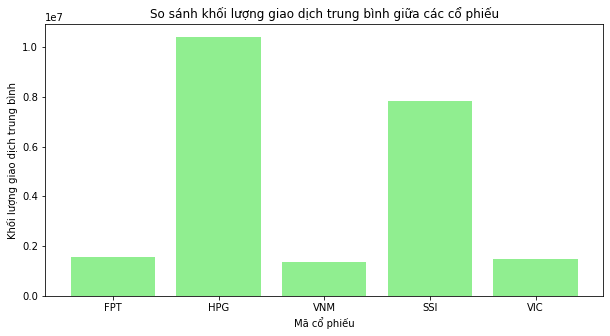

In [14]:
import matplotlib.pyplot as plt
pdf = summary_stats.toPandas()
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
plt.bar(pdf['ticker'], pdf['avg_volume'], color='lightgreen')
plt.title("So sánh khối lượng giao dịch trung bình giữa các cổ phiếu")
plt.xlabel("Mã cổ phiếu")
plt.ylabel("Khối lượng giao dịch trung bình")
plt.show()

## Đánh giá xu hướng sinh lời và mức độ biến động của từng cổ phiếu theo từng tháng 

In [15]:
df_month = df_5.withColumn("month", F.month("time"))
monthly_stats = df_month.groupBy("ticker", "month").agg(
    F.mean("daily_return").alias("avg_month_return"),
    F.stddev("daily_return").alias("month_volatility")
).orderBy("ticker", "month")

monthly_stats.show(20, truncate=False)

+------+-----+---------------------+--------------------+
|ticker|month|avg_month_return     |month_volatility    |
+------+-----+---------------------+--------------------+
|FPT   |1    |0.0010939435193916712|0.0173839355636725  |
|FPT   |2    |0.0015338751935665346|0.018201807415793306|
|FPT   |3    |1.0734979787274917E-4|0.016469398108933133|
|FPT   |4    |0.001181781929161853 |0.019783605922233702|
|FPT   |5    |0.0019565202485256963|0.021298833137766798|
|FPT   |6    |6.704223407612924E-4 |0.015188529656569973|
|FPT   |7    |0.0020737157414013646|0.01633632575014353 |
|FPT   |8    |0.0016932128296507328|0.01646984187460699 |
|FPT   |9    |-5.602898690396821E-4|0.013760151011192564|
|FPT   |10   |-3.151667067749697E-4|0.014813397554525595|
|FPT   |11   |5.705425723964688E-4 |0.015450522307227802|
|FPT   |12   |6.068117085201158E-4 |0.012057741985287097|
|HPG   |1    |0.0015378654946442637|0.023789993275002072|
|HPG   |2    |0.002556330818054569 |0.02423449685173197 |
|HPG   |3    |

## Phân tích hiệu suất và rủi ro của 5 mã cổ phiếu 

In [16]:
risk_return = df_5.groupBy("ticker").agg(
    F.mean("daily_return").alias("avg_return"),
    F.stddev("daily_return").alias("volatility")
).orderBy(F.desc("avg_return"))

risk_return.show()


+------+--------------------+--------------------+
|ticker|          avg_return|          volatility|
+------+--------------------+--------------------+
|   VIC| 9.87447514189449E-4|0.019548993961355433|
|   HPG|9.565632453074821E-4|0.021140843428299524|
|   FPT|8.783916184936556E-4|0.016559472500407645|
|   SSI|6.631985054358985E-4| 0.02329601393018983|
|   VNM|6.360802185766779E-4|0.014880219984359951|
+------+--------------------+--------------------+



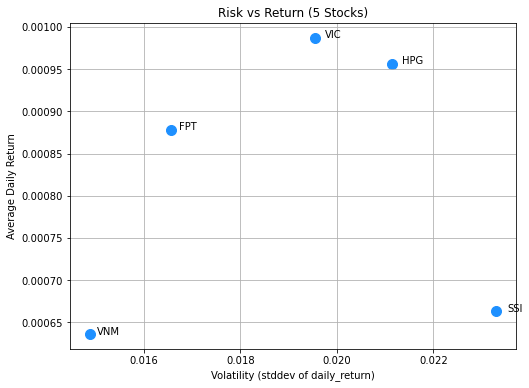

In [17]:
import matplotlib.pyplot as plt
risk_return_pd = risk_return.toPandas()

plt.figure(figsize=(8,6))
plt.scatter(risk_return_pd["volatility"], risk_return_pd["avg_return"], color="dodgerblue", s=100)
for i, txt in enumerate(risk_return_pd["ticker"]):
    plt.text(risk_return_pd["volatility"][i]*1.01, risk_return_pd["avg_return"][i], txt, fontsize=10)
plt.title("Risk vs Return (5 Stocks)")
plt.xlabel("Volatility (stddev of daily_return)")
plt.ylabel("Average Daily Return")
plt.grid(True)
plt.show()


## xu hướng giá trung bình theo thời gian 

In [18]:
avg_price_time = df_5.groupBy("ticker", "time").agg(F.mean("close").alias("avg_close"))

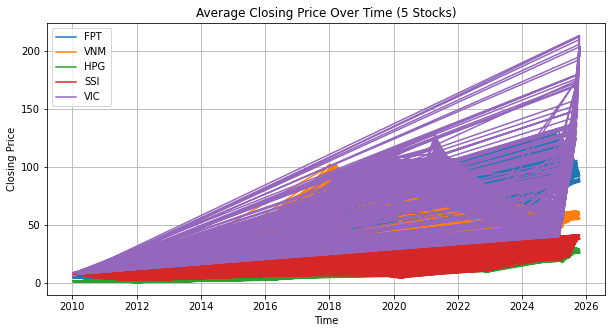

In [19]:
avg_price_pd = avg_price_time.toPandas()

plt.figure(figsize=(10,5))
for t in tickers:
    subset = avg_price_pd[avg_price_pd["ticker"] == t]
    plt.plot(subset["time"], subset["avg_close"], label=t)

plt.title("Average Closing Price Over Time (5 Stocks)")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()

# 4 Dự đoán giá mã cổ phiếu FPT

## Chuẩn bị dữ liệu 

Thực hiện lọc dữ liệu chỉ bao gồm mã cổ phiếu FPT,chuyển sang pandas và chia thành tập train/ test theo tỉ lệ 80-20 

In [20]:
import pandas as pd
import numpy as np
from pyspark.sql import functions as F

df_fpt_pd = df.filter(F.col("ticker")=="FPT").orderBy("time") \
              .select("time", "close").toPandas()

df_fpt_pd["close"] = df_fpt_pd["close"].astype(float)

train_size = int(len(df_fpt_pd) * 0.8)
train_data = df_fpt_pd.iloc[:train_size]
test_data = df_fpt_pd.iloc[train_size:]


Chuẩn hóa giá cổ phiếu FPT

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[["close"]])
test_scaled = scaler.transform(test_data[["close"]])


In [22]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 20
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Xây dựng mô hình LSTM để dự đoán 

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length,1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Huấn luyện mô hình 

In [24]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.1, shuffle=False)

Epoch 1/50
89/89 [==============================] - 6s 25ms/step - loss: 0.0011 - val_loss: 0.0138
Epoch 2/50
89/89 [==============================] - 2s 17ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 3/50
89/89 [==============================] - 2s 18ms/step - loss: 0.0025 - val_loss: 0.0128
Epoch 4/50
89/89 [==============================] - 2s 17ms/step - loss: 8.1547e-04 - val_loss: 0.0119
Epoch 5/50
89/89 [==============================] - 2s 19ms/step - loss: 5.6597e-04 - val_loss: 0.0032
Epoch 6/50
89/89 [==============================] - 2s 19ms/step - loss: 3.8141e-04 - val_loss: 0.0146
Epoch 7/50
89/89 [==============================] - 2s 17ms/step - loss: 8.4122e-04 - val_loss: 0.0018
Epoch 8/50
89/89 [==============================] - 1s 16ms/step - loss: 4.0387e-04 - val_loss: 0.0029
Epoch 9/50
89/89 [==============================] - 1s 17ms/step - loss: 8.6089e-04 - val_loss: 0.0163
Epoch 10/50
89/89 [==============================] - 1s 16ms/step - loss: 8.6885e-04 

In [25]:
pred_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))


25/25 [==============================] - 1s 8ms/step


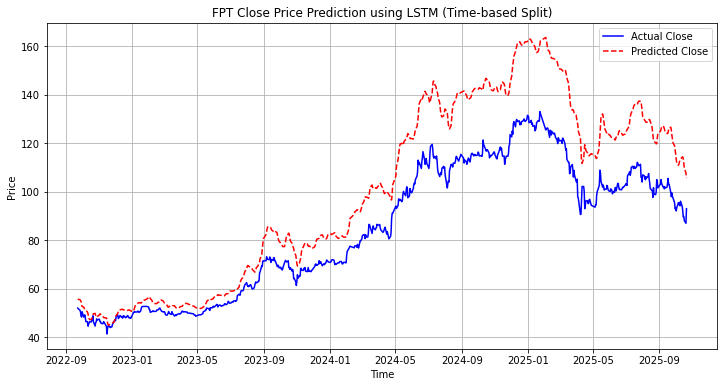

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(test_data["time"].iloc[seq_length:], y_test_actual, color='blue', label='Actual Close')
plt.plot(test_data["time"].iloc[seq_length:], predicted, color='red', linestyle='--', label='Predicted Close')
plt.title('FPT Close Price Prediction using LSTM (Time-based Split)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
